In [5]:
import os
import pandas as pd
import glob

# Get all top-level subfolders in the current directory
top_folders = [f.path for f in os.scandir('./') if f.is_dir() if f.name.startswith('classification_code')]

# Initialize an empty dictionary to store all results
all_results = {}

# Iterate over each top-level folder
for top_folder in top_folders:
    top_folder_name = os.path.basename(top_folder)
    all_results[top_folder_name] = pd.DataFrame()

    # Get second-level folders
    second_level_folders = [f.path for f in os.scandir(top_folder) if f.is_dir()]
    second_level_folders = [second_level_folders[i] for i in [2,1,3,0,4]]
    # Iterate over each second-level folder
    for second_folder in second_level_folders:
        # Find the result folder
        result_folder = os.path.join(second_folder, 'result')
        if not os.path.exists(result_folder):
            continue

        # Find all matching csv files
        csv_files = glob.glob(os.path.join(result_folder, 'Audio_cf_results_*.csv'))

        # Iterate over the found csv files
        for file in csv_files:
            # Read the csv file
            df = pd.read_csv(file)

            # Add two columns to indicate folder hierarchy
            samples = os.path.basename(top_folder)
            group = os.path.basename(second_folder)
            df['Samples'] = samples
            df['Group'] = group

            # Add the current DataFrame to the corresponding top-level folder results
            all_results[top_folder_name] = pd.concat([all_results[top_folder_name], df], ignore_index=True)

# Create a new DataFrame to store all combined results
combined_df = pd.DataFrame()

# Iterate over all top-level folder results
for folder, df in all_results.items():
    if not df.empty:
        # Move 'Samples' and 'Group' columns to the front
        cols = df.columns.tolist()
        cols = ['Samples', 'Group', "CM", "A", "D", "M", "N", "Feature"] + \
                [col for col in cols if col not in ['Samples', 'Group', "Feature", "CM", "A", "D", "M", "N", "MCC", "ROC", "ACC"]]
        df = df[cols]
        
        # Add the current DataFrame to the combined DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True)

# Write the combined DataFrame to an Excel file
combined_df.to_excel('./doc/combined_cf_results.xlsx', index=False, header=True)


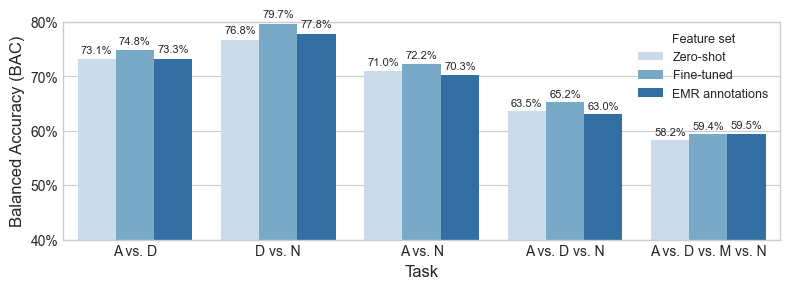

In [7]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


df = pd.read_excel('./doc/combined_cf_results.xlsx')

# Rename 'Group' column to 'Task' and add ' vs. ' between characters
df['Task'] = df['Group'].apply(lambda x: ' vs. '.join(list(x)))

# Rename feature names
df['Feature'] = df['Feature'].replace({
    'clinical-related-zs': 'Zero-shot',
    'clinical-related-sft': 'Fine-tuned',
    'clinical-related-gt': 'EMR annotations'
})

# Set the style to a white background
plt.style.use('seaborn-whitegrid')

# Create a single figure with a more journal-appropriate size
plt.figure(figsize=(8, 3))

# Sort the dataframe by BAC values for the first task (assuming it's 'AD')
feature_order = ['Zero-shot', 'Fine-tuned', 'EMR annotations']

# Create the bar plot with a blue color palette, using the sorted feature order
ax = sns.barplot(data=df, x='Task', y='BAC', hue='Feature', palette='Blues', hue_order=feature_order, ci=None)

# Add percentage labels on each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only add label if height is greater than 0
        ax.text(p.get_x() + p.get_width()/2., height * 1.01,
                f'{height:.1%}',
                ha="center", va="bottom", rotation=0, fontsize=8)

# Add title and labels with a more formal font
# plt.title('Balanced Accuracy by Task and Feature', fontsize=14, fontweight='bold')
plt.xlabel('Task', fontsize=12)
plt.ylabel('Balanced Accuracy (BAC)', fontsize=12)

# Rotate x-axis labels for better readability
# plt.xticks(rotation=0, ha='right', fontsize=10)

# Adjust y-axis range to [0.4, 0.8]
plt.ylim(0.4, 0.8)

# Add minor ticks for more precise reading
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.05))

# Adjust y-axis ticks to show percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Adjust legend
plt.legend(title='Feature set', loc='upper right', fontsize=9, title_fontsize=9)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

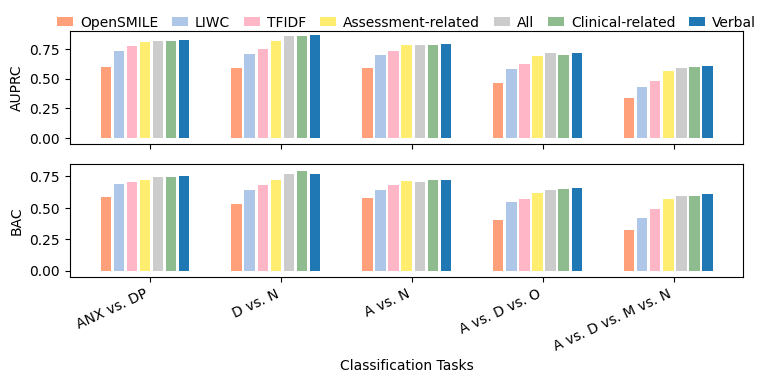

In [12]:
import warnings
import numpy as np

warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

test_sets = [["opensmile"], 
            ['LIWC'], 
            ["TFIDF"], 
            ['Assessment-related'],
            ['Assessment-related_LIWC_TFIDF_clinical-related-sft_opensmile'],
            ["clinical-related-sft"], 
            ['Assessment-related_LIWC_TFIDF_clinical-related-sft'], 
            ]

# Data preparation
df = pd.read_excel('./doc/combined_cf_results.xlsx')

# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4))
plt.style.use('default')

# Get unique groups and feature sets
groups = df['Group'].unique()
features = [item for sublist in test_sets for item in sublist]  # Keep original order

# Define colors for different feature sets
colors = ['#ffa07a', '#aec7e8', '#ffb6c6', '#ffed6f', '#cccccc', '#8fbc8f', '#1f77b4']
feature_colors = dict(zip(features, colors[:len(features)]))

# Create bar positions with spacing
bar_width = 0.08  # Reduced bar width
bar_spacing = 0.02  # Controls the gap between bars within each group
total_width = (bar_width + bar_spacing) * len(features) - bar_spacing  # Total width of each group
index = np.arange(len(groups))

# Plot AUPRC bars (first subplot)
for i, feature in enumerate(features):
    feature_data = df[df['Feature'] == feature]
    
    # Clean up feature names for display
    display_name = feature.replace('Assessment-related_LIWC_TFIDF_clinical-related-sft_opensmile', "All")\
                        .replace('Assessment-related_LIWC_TFIDF_clinical-related-sft', "Verbal")\
                        .replace('clinical-related-sft', 'Clinical-related')\
                        .replace('opensmile', 'OpenSMILE')\
                        .replace('_', ' + ')
    
    # Drop duplicated rows
    feature_data = feature_data.drop_duplicates(subset=['Group', 'Feature', 'BAC'])

    if len(feature_data) != len(index):
        print(f"Warning: Mismatch in data length for feature {feature}. Skipping this feature.")
        continue
    
    # Calculate bar positions with spacing
    bar_positions = index - total_width/2 + i * (bar_width + bar_spacing)
    
    # Plot AUPRC bars
    ax1.bar(bar_positions,
            feature_data['AUC'].values,
            bar_width,
            label=display_name,
            color=feature_colors[feature],
            capsize=3)

    # Plot BAC bars
    ax2.bar(bar_positions,
            feature_data['BAC'].values,
            bar_width,
            label=display_name,
            color=feature_colors[feature],
            capsize=3)

# Customize first subplot (AUPRC)
ax1.set_xlabel('')
ax1.set_ylabel('AUPRC')
ax1.set_xticks(index)
ax1.set_xticklabels([])
ax1.set_ylim(-0.05, 0.9)

# Add legend at the top of first subplot
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=len(features), fontsize=10,
          markerscale=1,
          handletextpad=0.5,
          columnspacing=1.0,
          handlelength=1.15,
          frameon=False)

# Customize second subplot (BAC)
ax2.set_xlabel('Classification Tasks')
ax2.set_ylabel('BAC')
ax2.set_xticks(index)
ax2.set_xticklabels([' vs. '.join(list(x.replace("ADN","ADO"))).replace("A vs. D", "ANX vs. DP").replace("ANX vs. DP vs.", "A vs. D vs.") for x in groups], rotation=25, ha='right')
ax2.set_ylim(-0.05, 0.85)

# Adjust layout
plt.tight_layout()

plt.show()